Here you will learn to submit your model 

*   List item
*   List item

to a machine learning competition in Python.  It's fun, and it will give you a way to see your progress as your skills keep improving.*

# Introduction
Machine learning competitions are a great way to improve your skills and measure your progress as a data scientist. If you are using data from a competition on Kaggle, you can easily submit it from your notebook.  Here's how you do it.

# Example
We're doing very minimal data set up here so we can focus on how to submit modeling results to competitions. Other tutorials will teach you how build great models. So the model in this example will be fairly simple. We'll start with the code to read data, select predictors, and fit a model.

## Define Constants

In [ ]:
DATA_PATH = "https://raw.githubusercontent.com/serivan/mldmlab/master/Kaggle/KAGGLE21/"
OUTPUT_PATH = "kaggle_submissions/"
RANDOM_STATE = 3993
TRAIN_SIZE = 0.8

DROPCOLUMS=["Id","target"]

#Insert here the description of your test in order to submit to Kaggle
Description="First submission test "

## Imports

In [ ]:
import os
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
# if not 'sklearn' in sys.modules.keys():
#    pip.main(['install', 'sklearn'])
# if not 'kaggle' in sys.modules.keys():
#    pip.main(['install', 'kaggle'])
import random
# import sys

# import pip

print("Random number with seed 2021")
# first call
random.seed(2021)

Random number with seed 2021


##Imports for Kaggle
See https://www.kaggle.com/docs/api

In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/gdrive/My Drive/kaggle.json" ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-23 11:40:36           3457  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2016  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            409  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1315  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

## Define Utils

Here we define a function for preperaing a submission file

In [ ]:
def generateSubmission(myModel, submissionFile, description):
    # Read the test data
    data = pd.read_csv(DATA_PATH + "test.csv")

    Id, X_test= data.Id,data.drop(columns=DROPCOLUMS)
    # Impute each test item, then predict
    X_test_imp = imp.transform(X_test)

    # Use the model to make predictions
    y_test_pred = myModel.predict(X_test_imp)
    # print(y_test_pred)

    # submission file
    my_submission = pd.DataFrame({"Id": Id, "target": y_test_pred})

    if not os.path.exists(OUTPUT_PATH):
      os.mkdir(OUTPUT_PATH)

    # you could use any filename. We choose submission here
    my_submission.to_csv(OUTPUT_PATH + submissionFile, index=False)

    # Submit authomatically; kaggle API authentication needed
    #!kaggle competitions submit -c heart-attack-analysis-and-prediction-21 -f {OUTPUT_PATH/submissionFile} -m '{description}'

## Load Data

In [ ]:
# Read the data
train = pd.read_csv(DATA_PATH + "train.csv")
train.dtypes

Id                       int64
st_slope               float64
age                    float64
chest_pain_type        float64
cholesterol            float64
exercise_angina        float64
fasting_blood_sugar    float64
max_heart_rate         float64
oldpeak                float64
pulse                  float64
resting_bp_s           float64
resting_ecg            float64
sex                    float64
synt                   float64
target                   int64
dtype: object

In [ ]:
train.head()

,Id,st_slope,age,chest_pain_type,cholesterol,exercise_angina,fasting_blood_sugar,max_heart_rate,oldpeak,pulse,resting_bp_s,resting_ecg,sex,synt,target
0,1000,1.0,62.0,2.0,213.0,0.0,1.0,141.0,-0.051026,348.0,128.0,2.0,1.0,0.536459,0
1,1001,2.0,72.0,3.0,2.0,0.0,0.0,115.0,1.626599,287.0,159.0,2.0,1.0,0.334897,0
2,1002,2.0,49.0,3.0,183.0,0.0,0.0,156.0,0.968111,391.0,161.0,0.0,0.0,0.720858,1
3,1003,1.0,35.0,2.0,NaN,0.0,0.0,179.0,0.021913,449.0,119.0,2.0,1.0,0.117560,0
4,1004,2.0,51.0,4.0,-4.0,0.0,1.0,104.0,-0.010970,258.0,120.0,0.0,1.0,0.790254,1


## Count missing values in columns

In [ ]:
number_of_missing_in_cols = train.shape[0] - train.count()
number_of_missing_in_cols

Id                       0
st_slope                 1
age                      4
chest_pain_type          9
cholesterol            202
exercise_angina          3
fasting_blood_sugar     11
max_heart_rate           7
oldpeak                  8
pulse                    3
resting_bp_s             7
resting_ecg              3
sex                      8
synt                     0
target                   0
dtype: int64

## Divide features by sematic type (binary, nominal, numerical)

In [ ]:
# Count the number of unique values in dataframe
cols_unique_vals_count = train.drop(columns=DROPCOLUMS).nunique().sort_values()
cols_unique_vals_count

exercise_angina           2
fasting_blood_sugar       2
sex                       2
resting_ecg               3
st_slope                  4
chest_pain_type           4
age                      49
resting_bp_s             87
max_heart_rate          121
cholesterol             222
pulse                   259
oldpeak                 947
synt                   1301
dtype: int64

In [ ]:
# If the column has only 2 unique values it is a binary col
BINARY_COLS = [col for col, val in cols_unique_vals_count.items() if val == 2]
BINARY_COLS

['exercise_angina', 'fasting_blood_sugar', 'sex']

In [ ]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NOMINAL_NUNIQUE_THRESHOLD = 10
NOMINAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > 2 and val < NOMINAL_NUNIQUE_THRESHOLD
]
NOMINAL_COLS

['resting_ecg', 'st_slope', 'chest_pain_type']

In [ ]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NUMERICAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > NOMINAL_NUNIQUE_THRESHOLD
]
NUMERICAL_COLS

['age',
 'resting_bp_s',
 'max_heart_rate',
 'cholesterol',
 'pulse',
 'oldpeak',
 'synt']

In [ ]:
# Create the categorical columns list as binary + nominal
CATEGORICAL_COLS = BINARY_COLS + NOMINAL_COLS
CATEGORICAL_COLS

['exercise_angina',
 'fasting_blood_sugar',
 'sex',
 'resting_ecg',
 'st_slope',
 'chest_pain_type']

## Feature engineering phase

In [ ]:
# Split dataset in data and target label
X_train, y_train = train.drop(columns=DROPCOLUMS), train.target

In [ ]:
# Create categorical transformer (binary + nominal)
# Replace imputer
categorical_transformer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

In [ ]:
# Create numeric transformer
# Impute missing values using the median value of each colum
numeric_transformer = SimpleImputer(missing_values=np.nan, strategy="median")

In [ ]:
# Create the imputer of mixed type columns
# ATTENTION: the preprocessor can be used in a Pipeline for simplicity
imputer = ColumnTransformer(
    transformers=[
        ("impute_numeric", numeric_transformer, NUMERICAL_COLS),
        ("impute_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)

In [ ]:
# Fit the imputer
imp = imputer.fit(X_train)
# Impute our data
X_train_imp = imp.transform(X_train)

[ColumnTransformer]  (1 of 2) Processing impute_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing impute_categorical, total=   0.0s


In [ ]:
# Column names after mixed imputation procedure
COLUMN_NAMES = NUMERICAL_COLS + CATEGORICAL_COLS
# Create a DataFrame from numpy array for visualization and simplicity
X_train_imp = pd.DataFrame(data=X_train_imp, columns=COLUMN_NAMES)
X_train_imp.head()

,age,resting_bp_s,max_heart_rate,cholesterol,pulse,oldpeak,synt,exercise_angina,fasting_blood_sugar,sex,resting_ecg,st_slope,chest_pain_type
0,62.0,128.0,141.0,213.0,348.0,-0.051026,0.536459,0.0,1.0,1.0,2.0,1.0,2.0
1,72.0,159.0,115.0,2.0,287.0,1.626599,0.334897,0.0,0.0,1.0,2.0,2.0,3.0
2,49.0,161.0,156.0,183.0,391.0,0.968111,0.720858,0.0,0.0,0.0,0.0,2.0,3.0
3,35.0,119.0,179.0,230.0,449.0,0.021913,0.117560,0.0,0.0,1.0,2.0,1.0,2.0
4,51.0,120.0,104.0,-4.0,258.0,-0.010970,0.790254,0.0,1.0,1.0,0.0,2.0,4.0


## Training

### You can train directly on the training set

In [ ]:
my_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
my_model.fit(X_train_imp, y_train)
my_model.score(X_train_imp, y_train)

1.0

In [ ]:
my_model.feature_importances_

array([0.06774393, 0.08956703, 0.04156462, 0.06936007, 0.06628662,
       0.10478481, 0.02520661, 0.01958205, 0.01301884, 0.04703054,
       0.0199307 , 0.31696414, 0.11896005])

In [ ]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    data=my_model.feature_importances_,
    index=X_train_imp.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
feature_importances

,importance
st_slope,0.316964
chest_pain_type,0.118960
oldpeak,0.104785
resting_bp_s,0.089567
cholesterol,0.069360
age,0.067744
pulse,0.066287
sex,0.047031
max_heart_rate,0.041565
synt,0.025207


In [ ]:
y_pred = my_model.predict(X_train_imp)
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

print("Classification Report:")
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[798   0]
 [  0 503]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       798
           1       1.00      1.00      1.00       503

    accuracy                           1.00      1301
   macro avg       1.00      1.00      1.00      1301
weighted avg       1.00      1.00      1.00      1301



In [ ]:
# generate a submission file
generateSubmission(my_model, "first_decision_tree.csv", Description)

### You can consider different models splitting in training and testing

In [ ]:
X_train_imp_2, X_test_imp_2, y_train_2, y_test_2 = train_test_split(
    X_train_imp, y_train, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)

In [ ]:
classification_tree = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
classification_tree.fit(X_train_imp_2, y_train_2)
classification_tree.score(X_train_imp_2, y_train_2)

0.8355769230769231

In [ ]:
classification_tree.score(X_test_imp_2, y_test_2)

0.8199233716475096

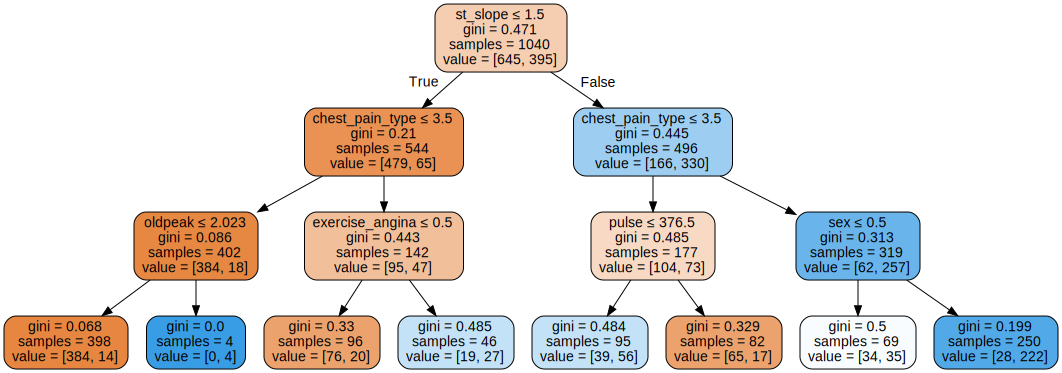

In [ ]:
# Visualize Decision Tree
dot_data = export_graphviz(
    decision_tree=classification_tree,
    out_file="decision_tree_heart_desease.dot",
    feature_names=COLUMN_NAMES,
    filled=True,
    rounded=True,
    special_characters=True,
)

# Read the dot graph and display image
with open("decision_tree_heart_desease.dot") as f:
    dot_graph = f.read()

# display(graphviz.Source(dot_graph))
display(graphviz.Source(dot_graph))

In [ ]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    classification_tree.feature_importances_,
    index=COLUMN_NAMES,
    columns=["importance"],
).sort_values("importance", ascending=False)
feature_importances

,importance
st_slope,0.613935
chest_pain_type,0.208064
sex,0.062264
pulse,0.051050
exercise_angina,0.035408
oldpeak,0.029279
age,0.000000
resting_bp_s,0.000000
max_heart_rate,0.000000
cholesterol,0.000000


In [ ]:
y_pred_2 = classification_tree.predict(X_test_imp_2)
print("Confusion Matrix:")
print(confusion_matrix(y_test_2, y_pred_2))

print("Classification Report:")
print(classification_report(y_test_2, y_pred_2))

Confusion Matrix:
[[125  28]
 [ 19  89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       153
           1       0.76      0.82      0.79       108

    accuracy                           0.82       261
   macro avg       0.81      0.82      0.82       261
weighted avg       0.82      0.82      0.82       261



In [ ]:
classification_tree.fit(X_train_imp, y_train)
classification_tree.score(X_train_imp, y_train)

0.8324365872405841

In [ ]:
# generate a submission file
generateSubmission(
    classification_tree,
    "second_decision_tree.csv",
    "User defined decision tree evaluated with test set",
)

### Or you can consider different models using cross validation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Average score: 0.8447445684086905')

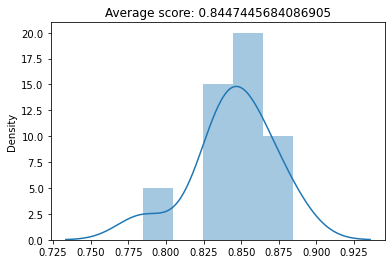

In [ ]:
dtc = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    dtc, X_train_imp, y_train, cv=10, scoring="accuracy", verbose=1
)
sns.distplot(cv_scores)
plt.title("Average score: {}".format(np.mean(cv_scores)))

In [ ]:
dtc.fit(X_train_imp, y_train)
dtc.score(X_train_imp, y_train)

0.8670253651037664

In [ ]:
# generate a submission file
generateSubmission(
    dtc,
    "crossval_decision_tree.csv",
    "User defined decision tree evaluated with cross validation",
)

### Parameter Tuning

In every classification technique, there are some parameters that can be tuned to optimize the classification. Some parameters that can be tuned in the decision tree is max depth (the depth of the tree), max feature (the feature used to classify), criterion, and splitter.

To search to tune parameter is to use Grid Search. Basically, it explores a range of parameters and finds the best combination of parameters. Then repeat the process several times until the best parameters are discovered. We will also use Stratified k-fold cross-validation that will prevent a certain class only split them to the same subset.

In [ ]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
# Create the parameter grids
parameter_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [2, 3, 4, 5, 6, 7, 8],
    "max_features": ["sqrt", "log2", None],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)
cross_validation.get_n_splits(X_train_imp, y_train)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(X_train_imp, y_train)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:    9.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              pres...
                                              random_state=3993,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param

In [ ]:
# grid_search.cv_results_

In [ ]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.8854726952436878
Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'splitter': 'best'}


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3993, splitter='best')

In [ ]:
my_model = best_dtc
my_model.fit(X_train_imp, y_train)
my_model.score(X_train_imp, y_train)

0.9692544196771714

In [ ]:
y_pred = my_model.predict(X_train_imp)
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

print("Classification Report:")
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[781  17]
 [ 23 480]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       798
           1       0.97      0.95      0.96       503

    accuracy                           0.97      1301
   macro avg       0.97      0.97      0.97      1301
weighted avg       0.97      0.97      0.97      1301



In [ ]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    my_model.feature_importances_, index=COLUMN_NAMES, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importances

,importance
st_slope,0.357018
chest_pain_type,0.127621
resting_bp_s,0.094524
oldpeak,0.087657
cholesterol,0.064682
pulse,0.058008
age,0.056920
sex,0.051895
max_heart_rate,0.044588
exercise_angina,0.017034


### Submit the final model

In [ ]:
# generate a submission file
generateSubmission(
    my_model,
    "gridcv_decision_tree.csv",
    "User defined decision tree evaluated with grid search",
)

Step by step commands...

In addition to your training data, there will be test data. This is frequently stored in a file with the title `test.csv`. This data won't include a column with your target (y), because that is what we'll have to predict and submit.  Here is sample code to do that. 

In [ ]:
# Read the test data
data = pd.read_csv(DATA_PATH + "test.csv")


Id, X_test= data.Id,data.drop(columns=DROPCOLUMS)
# Impute each test item, then predict
X_test_imp = imp.transform(X_test)

# Use the model to make predictions
y_test_pred = my_model.predict(X_test_imp)
print(y_test_pred)

[0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1
 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0
 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1
 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1
 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1
 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0]


# Prepare Submission File
We make submissions in CSV files.  Your submissions usually have two columns: an ID column and a prediction column.  The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the housing data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's `to_csv` method to write our submission file.  Explicitly include the argument `index=False` to prevent pandas from adding another column in our csv file.

In [ ]:
# submission file
my_submission = pd.DataFrame({"Id": Id, "target": y_test_pred})
# you could use any filename. We choose submission here
my_submission.to_csv(OUTPUT_PATH + "submission.csv", index=False)

# Make Submission
Hit the blue **Publish** button at the top of your notebook screen.  It will take some time for your kernel to run.  When it has finished your navigation bar at the top of the screen will have a tab for **Output**.  This only shows up if you have written an output file (like we did in the **Prepare Submission File** step).  

Otherwise, if you have a kaggle API token (https://www.kaggle.com/docs/api#getting-started-installation-&-authentication), you can use the following command (remove the '#'):

In [ ]:
# 
!kaggle competitions submit -c  heart-attack-analysis-and-prediction-21 -f kaggle_submissions/submission.csv -m "Please describe the technique used"

100% 1.30k/1.30k [00:02<00:00, 548B/s]
Successfully submitted to UNIBS Heart Attack Analysis & Prediction


# Last Steps 
Click on the Output button.  This will bring you to a screen with an option to **Submit to Competition**.  Hit that and you will see how your model performed.

If you want to go back to improve your model, click the Edit button, which re-opens the kernel.  You'll need to re-run all the cells when you re-open the kernel.

# Conclusion
You've completed Level 1 of Machine Learning.  Congrats.  

If you are ready to keep improving your model (and your skills), start level 2 of [Learn Machine Learning](https://www.kaggle.com/learn/machine-learning). 

Level 2 covers more powerful models, techniques to include non-numeric data, and more.  You can make more submissions to the competition and climb up the leaderboard as you go through the course.


